# AutoGen - Stocks Prices demo

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

<img src="https://github.com/microsoft/autogen/blob/main/website/static/img/autogen_agentchat.png?raw=true">

> https://github.com/microsoft/autogen

In [1]:
# %pip install yfinance

In [2]:
import autogen
import datetime
import openai
import os
import pandas as pd
import requests
import yfinance as yf
import sys

from autogen import AssistantAgent, UserProxyAgent
from dotenv import load_dotenv

In [3]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 09-Nov-2023 09:43:46


## Configuration

In [5]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


In [6]:
!ls OAI_CONFIG_LIST -lh

-rwxrwxrwx 1 root root 242 Oct 25 11:19 OAI_CONFIG_LIST


In [7]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": [
            "gpt-4",
            "gpt-4-0314",
            "gpt4",
            "gpt-4-32k",
            "gpt-4-32k-0314",
            "gpt-4-32k-v0314",
        ],
    },
)

In [8]:
print("You have this required model:", config_list[0]["model"])

You have this required model: gpt-4-32k


## Functions

In [9]:
def is_termination_msg(data):
    """
    Check TERMINATE message
    """
    has_content = "content" in data and data["content"] is not None

    return has_content and "TERMINATE" in data["content"]

In [10]:
def get_prices_for_symbol(symbol: str, days: int) -> pd.DataFrame:
    """
    Get dataframe from stocks prices
    """
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(days=days)
    df = yf.download(symbol, start=start_date, end=end_date)

    df.reset_index(inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

In [11]:
def get_prices(days: int, symbol: str) -> str:
    """
    Get prices
    """
    symbol_df = get_prices_for_symbol(symbol, days)

    symbol_txt = symbol_df.to_string(index=None)
    return f"""
    
{symbol_txt}
    """.strip()

In [12]:
llm_config = {
    "config_list": config_list,
    "use_cache": False,
    "temperature": 0,
    "request_timeout": 120,
    "functions": [
        {
            "name": "get_prices",
            "description": "Get daily stock prices",
            "parameters": {
                "type": "object",
                "properties": {
                    "days": {"type": "integer", "description": "days"},
                    "symbol": {"type": "string", "description": "symbol"},
                },
                "required": ["days", "symbol"],
            },
        }
    ],
}

## Agents

In [13]:
analyst_msg = f"""
Financial Analyst: You are a Senior Financial Analyst responsible for a stock price indicator.

Follow the plan:
1. Obtain stock price data from the engineer.
2. Analyze the stock price data, provide financial comments, and pass it to the Python designer for chart creation.
3. Upon receiving the code from the Python designer along with the complete dataset, if it's not provided, kindly 
request the Python designer to provide the missing data.
4. Please include the closing prices only for the python chart.

Upon successful completion of the plan, add "TERMINATE" to conclude the message.
"""


analyst = AssistantAgent(
    name="analyst_person",
    system_message=analyst_msg,
    llm_config=llm_config,
    is_termination_msg=is_termination_msg,
    code_execution_config=False,
)

In [14]:
analyst

In [15]:
engineer_msg = f"""
Engineer. You are a Senior Software Engineer that executes the get_prices functions as requested by the Financial Analyst.
"""


engineer = AssistantAgent(
    name="engineer_person",
    system_message=engineer_msg,
    llm_config=llm_config,
    function_map={"get_prices": get_prices},
    code_execution_config=False,
)

In [16]:
engineer

In [17]:
python_expert_msg = f"""
Python Expert: You are a Senior Python developper with a specialization in creating charts using the
seaborn python library. Your job is to develop a stock chart using the closed stock price data supplied
by the Senior Financial Analyst.

Your responsibility involves:
1. Generating comprehensive code, including the actual COMPLETE data, for the Senior Analyst to successfully run the chart.
2. Ensuring that the code is prepared for immediate execution, WITHOUT ANY PLACEHOLDERS TEXT or missing data.
3. Guaranteeing the seamless integration of the received stock closed price data into the code.
4. Structuring the code for execution and utilizing the seaborn library to present the stock chart.
"""


pythonexpert = AssistantAgent(
    name="python_expert_person",
    system_message=python_expert_msg,
    code_execution_config=False,  # set to True or image name like "python:3" to use docker
    llm_config=llm_config,
)

In [18]:
pythonexpert

In [19]:
user_proxy = UserProxyAgent(
    name="admin",
    system_message="""
    Human Admin: Let's engage with the analyst to have a discussion about the stock price report. 
    Please ensure that the final report is shared with me for approval before it's finalized.
    """,
    code_execution_config=False,
    human_input_mode="NEVER",
    is_termination_msg=is_termination_msg,
)

In [20]:
user_proxy

In [21]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, analyst, pythonexpert, engineer], messages=[], max_round=20
)

manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config)

In [22]:
groupchat

GroupChat(agents=[<autogen.agentchat.user_proxy_agent.UserProxyAgent object at 0x7fd79aff2d40>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7fd79aff0670>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7fd75536f7c0>, <autogen.agentchat.assistant_agent.AssistantAgent object at 0x7fd79b019720>], messages=[], max_round=20, admin_name='Admin', func_call_filter=True)

In [23]:
manager

## Example 1

In [24]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [25]:
message = f"""
Analyze the stock prices for the MICROSOFT company for the last 15 days and generate a chart.
"""

user_proxy.initiate_chat(manager, clear_history=True, message=message)

admin (to chat_manager):


Analyze the stock prices for the MICROSOFT company for the last 15 days and generate a chart.


--------------------------------------------------------------------------------
analyst_person (to chat_manager):

***** Suggested function Call: get_prices *****
Arguments: 

{
  "days": 15,
  "symbol": "MSFT"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_prices...
[*********************100%%**********************]  1 of 1 completed
engineer_person (to chat_manager):

***** Response from calling function "get_prices" *****
Date       Open       High        Low      Close    Volume
2023-10-25 345.019989 346.200012 337.619995 340.670013  55053800
2023-10-26 340.540009 341.630005 326.940002 327.890015  37828500
2023-10-27 330.429993 336.720001 328.399994 329.809998  29856500
2023-10-30 333.410004 339.450012 331.829987 337.309998  22828100
2023-10-31

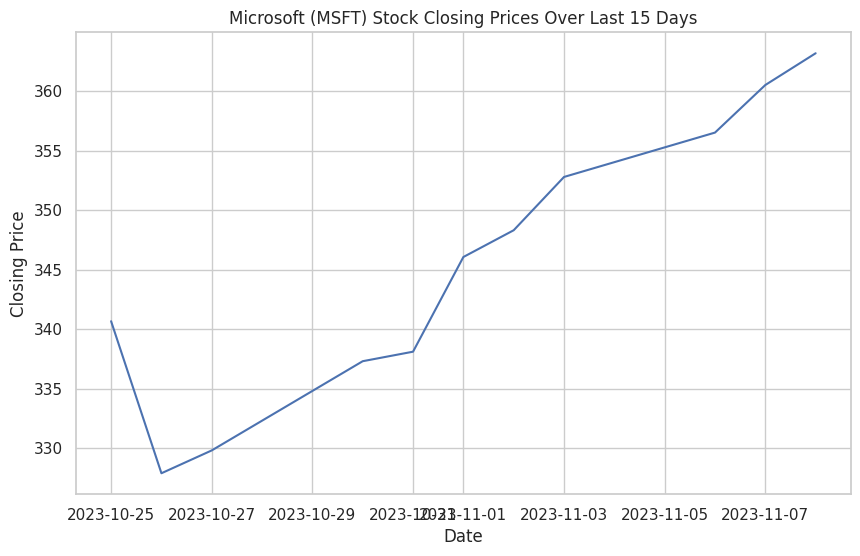

In [26]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe with the stock data
data = {
    'Date': ['2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-06', '2023-11-07', '2023-11-08'],
    'Close': [340.670013, 327.890015, 329.809998, 337.309998, 338.109985, 346.070007, 348.320007, 352.799988, 356.529999, 360.529999, 363.200012]
}

df = pd.DataFrame(data)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the style of seaborn plot
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y="Close", data=df)

# Set the title and labels of the plot
plt.title('Microsoft (MSFT) Stock Closing Prices Over Last 15 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Display the plot
plt.show()

## Example 2

In [27]:
message = f"""
Analyze the stock prices for the MICROSOFT company for the last 6 months and generate a chart.
"""

user_proxy.initiate_chat(manager, clear_history=True, message=message)

admin (to chat_manager):


Analyze the stock prices for the MICROSOFT company for the last 6 months and generate a chart.


--------------------------------------------------------------------------------
analyst_person (to chat_manager):

***** Suggested function Call: get_prices *****
Arguments: 

{
  "days": 180,
  "symbol": "MSFT"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_prices...
[*********************100%%**********************]  1 of 1 completed
engineer_person (to chat_manager):

***** Response from calling function "get_prices" *****
Date       Open       High        Low      Close    Volume
2023-05-15 309.100006 309.899994 307.589996 309.459991  16336500
2023-05-16 309.829987 313.709991 309.829987 311.739990  26730300
2023-05-17 312.290009 314.429993 310.739990 314.000000  24315000
2023-05-18 314.529999 319.040009 313.720001 318.519989  27276000
2023-05-

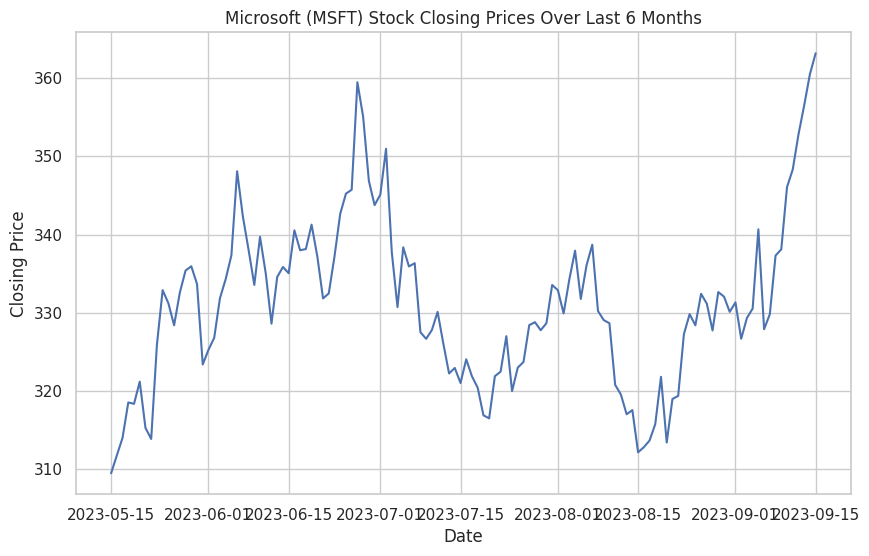

In [40]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe with the stock data
data = {
    'Date': pd.date_range(start='2023-05-15', periods=124),
    'Close': [309.459991, 311.739990, 314.000000, 318.519989, 318.339996, 321.179993, 315.260010, 313.850006, 325.920013, 332.890015, 331.209991, 328.390015, 332.579987, 335.399994, 335.940002, 333.679993, 323.380005, 325.260010, 326.790009, 331.850006, 334.290009, 337.339996, 348.100006, 342.329987, 338.049988, 333.559998, 339.709991, 335.019989, 328.600006, 334.570007, 335.850006, 335.049988, 340.540009, 337.989990, 338.149994, 341.269989, 337.220001, 331.829987, 332.470001, 337.200012, 342.660004, 345.239990, 345.730011, 359.489990, 355.079987, 346.869995, 343.769989, 345.109985, 350.980011, 337.769989, 330.720001, 338.369995, 335.920013, 336.339996, 327.500000, 326.660004, 327.779999, 330.109985, 326.049988, 322.230011, 322.929993, 321.010010, 324.040009, 321.859985, 320.399994, 316.880005, 316.480011, 321.880005, 322.459991, 327.000000, 319.970001, 322.980011, 323.700012, 328.410004, 328.790009, 327.760010, 328.660004, 333.549988, 332.880005, 329.910004, 334.269989, 337.940002, 331.769989, 336.059998, 338.700012, 330.220001, 329.059998, 328.649994, 320.769989, 319.529999, 317.010010, 317.540009, 312.140015, 312.790009, 313.640015, 315.750000, 321.799988, 313.390015, 318.959991, 319.359985, 327.260010, 329.820007, 328.390015, 332.420013, 331.160004, 327.730011, 332.640015, 332.059998, 330.109985, 331.320007, 326.670013, 329.320007, 330.529999, 340.670013, 327.890015, 329.809998, 337.309998, 338.109985, 346.070007, 348.320007, 352.799988, 356.529999, 360.529999, 363.200012]
}

df = pd.DataFrame(data)

# Set the style of seaborn plot
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y="Close", data=df)

# Set the title and labels of the plot
plt.title('Microsoft (MSFT) Stock Closing Prices Over Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Display the plot
plt.show()

## Example 3

In [30]:
message = f"""
Analyze the stock prices for the APPLE company for the last 20 days and generate a chart.
"""

user_proxy.initiate_chat(manager, clear_history=True, message=message)

admin (to chat_manager):


Analyze the stock prices for the APPLE company for the last 20 days and generate a chart.


--------------------------------------------------------------------------------
analyst_person (to chat_manager):

***** Suggested function Call: get_prices *****
Arguments: 

{
  "days": 20,
  "symbol": "AAPL"
}
***********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_prices...
[*********************100%%**********************]  1 of 1 completed
engineer_person (to chat_manager):

***** Response from calling function "get_prices" *****
Date       Open       High        Low      Close    Volume
2023-10-20 175.309998 175.419998 172.639999 172.880005  64189300
2023-10-23 170.910004 174.009995 169.929993 173.000000  55980100
2023-10-24 173.050003 173.669998 171.449997 173.440002  43816600
2023-10-25 171.880005 173.059998 170.649994 171.100006  57157000
2023-10-26 170

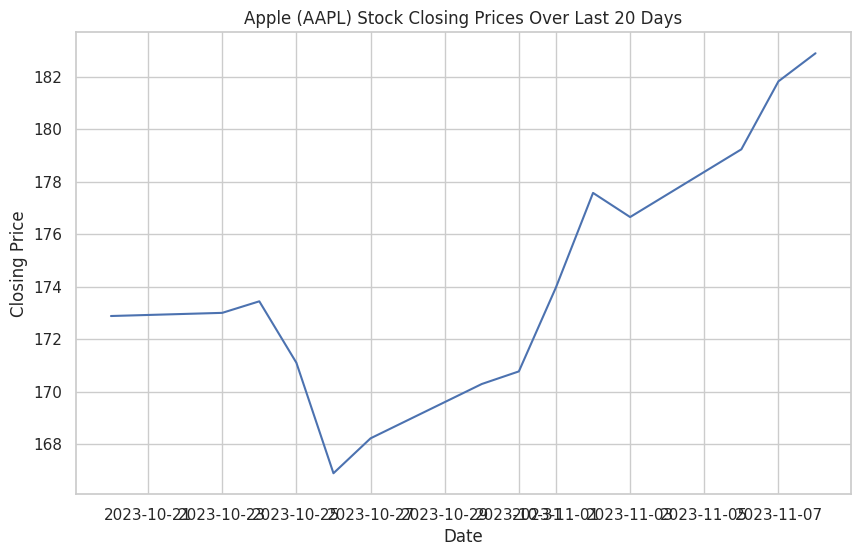

In [31]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dataframe with the stock data
data = {
    'Date': ['2023-10-20', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-06', '2023-11-07', '2023-11-08'],
    'Close': [172.880005, 173.000000, 173.440002, 171.100006, 166.889999, 168.220001, 170.289993, 170.770004, 173.970001, 177.570007, 176.649994, 179.229996, 181.820007, 182.889999]
}

df = pd.DataFrame(data)

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the style of seaborn plot
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Date", y="Close", data=df)

# Set the title and labels of the plot
plt.title('Apple (AAPL) Stock Closing Prices Over Last 20 Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Display the plot
plt.show()